In [72]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [73]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Detector e Descritor

- computei o detector e descritor de um batch para criar massa de dados para a rede siamesa

In [74]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points,extract_features_with_box
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
from training import KeyEqGroup, KeyPointsSelection
torch.__version__


def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 15
    args.margin_loss = 2.0
    args.border  = 15
    args.nms_size = 10 # normal é 10, alterei so pra avaliar o match
    args.box_size = 31
    args.exported = False
    return args


args = custom_config(args)
n_bin = 6
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)




MODEL_PATH = "./data/models/model_flowers_ssim.pt"

single_point_model = load_model_trained(args,device,path=MODEL_PATH)
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

Já foi treinado
epoca 100 loss 3.5150668924930053
15 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Segementa todas as features de batch só

pos predict  torch.Size([15, 1, 180, 180]) torch.Size([15, 1, 180, 180])


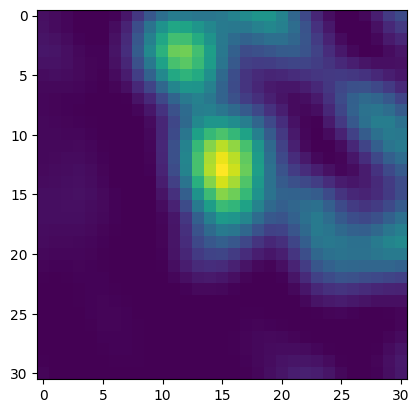

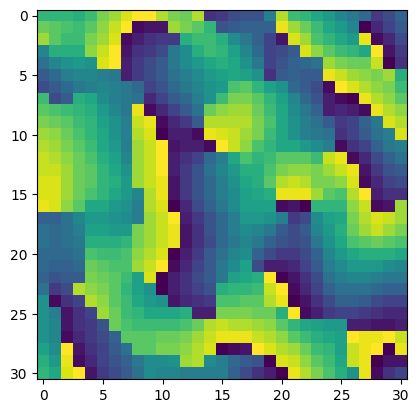

In [75]:
feature,orien1 = predict_single_points(single_point_model,batch)
batch_result,coords = extract_features_with_box(feature,orien1)

# concatena em um tensor somente as features e orientações
for i,(boxs,mini_feat_batch,mini_orien_batch) in enumerate(batch_result):
    if i==0:
        mini_feat_batch_concat = mini_feat_batch
        mini_orien_batch_concat = mini_orien_batch
    else:
        mini_feat_batch_concat = torch.cat([mini_feat_batch_concat,mini_feat_batch], dim=0)
        mini_orien_batch_concat = torch.cat([mini_orien_batch_concat,mini_orien_batch], dim=0)
    # print('batch ',i,mini_orien_batch_concat.shape)

mini_dataloader = torch.stack([mini_feat_batch_concat,mini_orien_batch_concat], dim=1)#TODO colocar orientacao depois

plt.imshow(mini_dataloader[0,0,:,:].cpu().detach())
plt.show()
plt.imshow(mini_dataloader[0,1,:,:].cpu().detach())
plt.show()

#### Dividi o array em batch de train e test de tamanho 10

In [76]:
import torch
from torch.utils.data import DataLoader, random_split

# Definindo o tamanho do lote desejado
batch_size = 10

# Dividindo o tensor em conjuntos de treinamento e teste
train_ratio = 0.8
train_size = int(train_ratio * len(mini_dataloader))
test_size = len(mini_dataloader) - train_size

train_tensor, test_tensor = random_split(mini_dataloader, [train_size, test_size])

# Criando os dataloaders para treinamento e teste
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

# Verificando o tamanho dos conjuntos de treinamento e teste (em número de lotes)
print(len(train_loader))  # Saída: 64 (80% de 800 dividido por 10)
print(len(test_loader))  # Saída: 16 (20% de 800 dividido por 10)


100
25


### Define arquitetura do modelo de rede siamesa

In [77]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [78]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 5*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(
                enn.MaskModule(feat_type_in, n_dim, margin=2),
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=1, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 1*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=2, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        # self.pool2 = enn.PointwiseAvgPool(feat_type_out, 21)
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)        
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.gpool(x)   
        return x.tensor
    

class Discriminator(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()
        #criar camadas densa a partir de x que é uma cnn
        self.dense1 = nn.Linear(2*1*25*25, 256)
        self.dense2 = nn.Linear(256, 128)
        #função de ativação ideal para retornar um valor entre 0 e 1
        self.activation = nn.Sigmoid()

    
    def forward(self,X1,X2)->torch.Tensor:
        flatten_x1 = X1.view(X1.size(0), -1)
        flatten_x2 = X2.view(X2.size(0), -1)
      
        x = torch.cat((flatten_x1,flatten_x2),dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        # Calculando a diferença entre os embeddings
        # diff = flatten_x1 - flatten_x2
        # Calculando a distância euclidiana
        distance = torch.norm(x, dim=1)
        x = self.activation(distance)
        return x


class Siamesa(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
            super().__init__()
            self.feature = Feature(n_dim=n_dim,n_channel=n_channel)
            self.discriminator = Discriminator()
    
    def forward(self,X1,X2)->torch.Tensor:
        x1 = self.feature(X1)
        x2 = self.feature(X2)
        x = self.discriminator(x1,x2)
        return x
    

X1=torch.rand(8,2,31,31).to(device)
X2=torch.rand(8,2,31,31).to(device)

model =Siamesa(n_dim=31,n_channel=2).to(device)
temp = model(X1,X2)

temp


tensor([0.9942, 0.9929, 0.9948, 0.9903, 0.9866, 0.9914, 0.9920, 0.9923],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

### Metodos para o processo de treinamento

In [79]:
from tqdm import tqdm

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_fn,device='cpu'):
    model.train()
    total_loss = 0.

    for data in tqdm(train_loader, desc="Train "):
        data = data.to(device)
        optimizer.zero_grad()            

        #refactor block
        data_pos = random_transform(data)
        output_pos = model(data,data_pos)
        #sift rool data
        data_neg =torch.roll(data_pos, 1, 0)
        output_neg = model(data,data_neg)

        #calculate loss
        loss = loss_fn(output_pos,output_neg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)
    

#Create methods to calculate loss
def loss_fn(output_pos,output_neg):    
    margim = 0.5
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    # print(loss)
    loss = torch.sum(loss)  # Reduzir para um escalar
    return loss

#Create methods random_transform with kornia with import
import kornia
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=(-180., 180.),translate=(0.05,0.05),scale=(0.95,1.05))(x)
    return x


In [80]:
model =Siamesa(n_dim=31,n_channel=2).to(device)
model(X1,X1)

tensor([0.9977, 0.9956, 0.9948, 0.9931, 0.9937, 0.9972, 0.9960, 0.9956],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [81]:
from torch.optim.lr_scheduler import ExponentialLR

def train(model,train_loader,test_loader,loss_fn,epochs=10,device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = ExponentialLR(optimizer, gamma=0.75)
    for epoch in range(epochs):
        loss_train = train_one_epoch(model,train_loader,optimizer,loss_fn,device)
        loss_test = test(model,test_loader,loss_fn,device)
        print()
        if (epoch % 15 == 0) and (epoch != 0):
            scheduler.step()
        print('initial_lr ',optimizer.param_groups[0]['initial_lr'],'lr ', optimizer.param_groups[0]['lr'])
        print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}')
        

train(model,train_loader,test_loader,loss_fn,epochs=150,device=device)

Tests : 100%|██████████| 25/25 [00:00<00:00, 66.98it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 0, Train Loss: 0.4703, Test Loss: 0.4300


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.25it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 1, Train Loss: 0.3773, Test Loss: 0.3764


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.34it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 2, Train Loss: 0.3393, Test Loss: 0.3440


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.46it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 3, Train Loss: 0.3309, Test Loss: 0.3563


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.45it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 4, Train Loss: 0.3163, Test Loss: 0.3248


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.89it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 5, Train Loss: 0.3095, Test Loss: 0.3042


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.78it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 6, Train Loss: 0.3030, Test Loss: 0.2818


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.83it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 7, Train Loss: 0.2820, Test Loss: 0.3048


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.28it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 8, Train Loss: 0.2931, Test Loss: 0.2919


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.21it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 9, Train Loss: 0.2737, Test Loss: 0.2725


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.48it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 10, Train Loss: 0.2674, Test Loss: 0.2859


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.04it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 11, Train Loss: 0.2542, Test Loss: 0.2555


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.03it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 12, Train Loss: 0.2532, Test Loss: 0.2630


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.88it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 13, Train Loss: 0.2448, Test Loss: 0.2701


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.49it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 14, Train Loss: 0.2393, Test Loss: 0.2352


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.90it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 15, Train Loss: 0.2270, Test Loss: 0.2459


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.93it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 16, Train Loss: 0.2267, Test Loss: 0.2457


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.98it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 17, Train Loss: 0.2207, Test Loss: 0.2159


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.45it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 18, Train Loss: 0.2173, Test Loss: 0.2069


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.14it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 19, Train Loss: 0.2246, Test Loss: 0.2311


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.81it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 20, Train Loss: 0.2199, Test Loss: 0.2215


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.70it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 21, Train Loss: 0.2214, Test Loss: 0.2478


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.52it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 22, Train Loss: 0.2160, Test Loss: 0.2028


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.21it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 23, Train Loss: 0.2090, Test Loss: 0.1982


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.72it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 24, Train Loss: 0.2117, Test Loss: 0.2400


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.28it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 25, Train Loss: 0.2095, Test Loss: 0.2044


Tests : 100%|██████████| 25/25 [00:00<00:00, 60.58it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 26, Train Loss: 0.2074, Test Loss: 0.2197


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.47it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 27, Train Loss: 0.2035, Test Loss: 0.2160


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.47it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 28, Train Loss: 0.2135, Test Loss: 0.1817


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.36it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 29, Train Loss: 0.2071, Test Loss: 0.2303


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.32it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 30, Train Loss: 0.1961, Test Loss: 0.2022


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.24it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 31, Train Loss: 0.2068, Test Loss: 0.2000


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.21it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 32, Train Loss: 0.1952, Test Loss: 0.1848


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.51it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 33, Train Loss: 0.1947, Test Loss: 0.1826


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.61it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 34, Train Loss: 0.1933, Test Loss: 0.2016


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.27it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 35, Train Loss: 0.1911, Test Loss: 0.2138


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.76it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 36, Train Loss: 0.2031, Test Loss: 0.1842


Tests : 100%|██████████| 25/25 [00:00<00:00, 59.55it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 37, Train Loss: 0.1914, Test Loss: 0.1769


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.24it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 38, Train Loss: 0.1938, Test Loss: 0.1964


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.47it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 39, Train Loss: 0.2030, Test Loss: 0.1932


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.33it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 40, Train Loss: 0.1925, Test Loss: 0.1880


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.19it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 41, Train Loss: 0.1974, Test Loss: 0.2011


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.90it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 42, Train Loss: 0.1987, Test Loss: 0.1732


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.45it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 43, Train Loss: 0.1974, Test Loss: 0.1896


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.35it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 44, Train Loss: 0.1983, Test Loss: 0.2007


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.79it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 45, Train Loss: 0.1996, Test Loss: 0.1819


Tests : 100%|██████████| 25/25 [00:00<00:00, 61.66it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 46, Train Loss: 0.1871, Test Loss: 0.2167


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.68it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 47, Train Loss: 0.1957, Test Loss: 0.1920


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.19it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 48, Train Loss: 0.1791, Test Loss: 0.1843


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.39it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 49, Train Loss: 0.1883, Test Loss: 0.1923


Tests : 100%|██████████| 25/25 [00:00<00:00, 61.82it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 50, Train Loss: 0.1973, Test Loss: 0.1791


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.13it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 51, Train Loss: 0.1903, Test Loss: 0.1747


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.19it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 52, Train Loss: 0.1958, Test Loss: 0.1864


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.22it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 53, Train Loss: 0.1876, Test Loss: 0.1719


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.29it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 54, Train Loss: 0.1905, Test Loss: 0.1776


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.44it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 55, Train Loss: 0.1865, Test Loss: 0.1836


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.92it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 56, Train Loss: 0.1923, Test Loss: 0.1755


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.92it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 57, Train Loss: 0.1902, Test Loss: 0.1869


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.49it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 58, Train Loss: 0.1920, Test Loss: 0.1851


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.53it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 59, Train Loss: 0.1899, Test Loss: 0.1783


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.33it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 60, Train Loss: 0.1823, Test Loss: 0.1748


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.88it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 61, Train Loss: 0.1799, Test Loss: 0.1905


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.17it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 62, Train Loss: 0.1882, Test Loss: 0.1816


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.89it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 63, Train Loss: 0.1828, Test Loss: 0.1806


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.18it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 64, Train Loss: 0.1795, Test Loss: 0.2103


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.15it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 65, Train Loss: 0.1829, Test Loss: 0.1783


Tests : 100%|██████████| 25/25 [00:00<00:00, 60.95it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 66, Train Loss: 0.1759, Test Loss: 0.1790


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.77it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 67, Train Loss: 0.1799, Test Loss: 0.1941


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.64it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 68, Train Loss: 0.1879, Test Loss: 0.1714


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.63it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 69, Train Loss: 0.1827, Test Loss: 0.1781


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.88it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 70, Train Loss: 0.1811, Test Loss: 0.1791


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.62it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 71, Train Loss: 0.1759, Test Loss: 0.1747


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.56it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 72, Train Loss: 0.1859, Test Loss: 0.1735


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.42it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 73, Train Loss: 0.1836, Test Loss: 0.1666


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.70it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 74, Train Loss: 0.1839, Test Loss: 0.1775


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.68it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 75, Train Loss: 0.1769, Test Loss: 0.1658


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.21it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 76, Train Loss: 0.1823, Test Loss: 0.1738


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.19it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 77, Train Loss: 0.1779, Test Loss: 0.1760


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.21it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 78, Train Loss: 0.1812, Test Loss: 0.1791


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.19it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 79, Train Loss: 0.1641, Test Loss: 0.1799


Tests : 100%|██████████| 25/25 [00:00<00:00, 61.09it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 80, Train Loss: 0.1883, Test Loss: 0.1675


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.07it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 81, Train Loss: 0.1770, Test Loss: 0.1892


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.43it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 82, Train Loss: 0.1804, Test Loss: 0.1570


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.10it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 83, Train Loss: 0.1820, Test Loss: 0.1813


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.27it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 84, Train Loss: 0.1750, Test Loss: 0.1817


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.19it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 85, Train Loss: 0.1725, Test Loss: 0.1596


Tests : 100%|██████████| 25/25 [00:00<00:00, 60.14it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 86, Train Loss: 0.1819, Test Loss: 0.1715


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.63it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 87, Train Loss: 0.1809, Test Loss: 0.1838


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.91it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 88, Train Loss: 0.1818, Test Loss: 0.2001


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.85it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 89, Train Loss: 0.1847, Test Loss: 0.1683


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.89it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 90, Train Loss: 0.1718, Test Loss: 0.1779


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.95it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 91, Train Loss: 0.1771, Test Loss: 0.1740


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.98it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 92, Train Loss: 0.1804, Test Loss: 0.1779


Tests : 100%|██████████| 25/25 [00:00<00:00, 60.50it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 93, Train Loss: 0.1780, Test Loss: 0.1671


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.40it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 94, Train Loss: 0.1771, Test Loss: 0.1771


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.93it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 95, Train Loss: 0.1763, Test Loss: 0.1662


Tests : 100%|██████████| 25/25 [00:00<00:00, 61.45it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 96, Train Loss: 0.1776, Test Loss: 0.1855


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.80it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 97, Train Loss: 0.1826, Test Loss: 0.1706


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.64it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 98, Train Loss: 0.1798, Test Loss: 0.1730


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.95it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 99, Train Loss: 0.1770, Test Loss: 0.1773


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.27it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 100, Train Loss: 0.1831, Test Loss: 0.1715


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.79it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 101, Train Loss: 0.1846, Test Loss: 0.1723


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.64it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 102, Train Loss: 0.1789, Test Loss: 0.1803


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.76it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 103, Train Loss: 0.1751, Test Loss: 0.1783


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.15it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 104, Train Loss: 0.1745, Test Loss: 0.1776


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.13it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 105, Train Loss: 0.1818, Test Loss: 0.1643


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.92it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 106, Train Loss: 0.1793, Test Loss: 0.1854


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.37it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 107, Train Loss: 0.1773, Test Loss: 0.1772


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.92it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 108, Train Loss: 0.1771, Test Loss: 0.1711


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.12it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 109, Train Loss: 0.1703, Test Loss: 0.1805


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.20it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 110, Train Loss: 0.1703, Test Loss: 0.1667


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.24it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 111, Train Loss: 0.1844, Test Loss: 0.1730


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.09it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 112, Train Loss: 0.1692, Test Loss: 0.1696


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.87it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 113, Train Loss: 0.1745, Test Loss: 0.1548


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.89it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 114, Train Loss: 0.1724, Test Loss: 0.1716


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.17it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 115, Train Loss: 0.1745, Test Loss: 0.1595


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.81it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 116, Train Loss: 0.1814, Test Loss: 0.1662


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.60it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 117, Train Loss: 0.1770, Test Loss: 0.1605


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.33it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 118, Train Loss: 0.1788, Test Loss: 0.1662


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.07it/s]



initial_lr  0.0001 lr  1.3348388671874999e-05
Epoch: 119, Train Loss: 0.1696, Test Loss: 0.1706


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.11it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 120, Train Loss: 0.1676, Test Loss: 0.1771


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.81it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 121, Train Loss: 0.1770, Test Loss: 0.1938


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.09it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 122, Train Loss: 0.1749, Test Loss: 0.1716


Tests : 100%|██████████| 25/25 [00:00<00:00, 61.24it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 123, Train Loss: 0.1758, Test Loss: 0.1597


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.56it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 124, Train Loss: 0.1715, Test Loss: 0.1753


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.17it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 125, Train Loss: 0.1641, Test Loss: 0.1666


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.23it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 126, Train Loss: 0.1745, Test Loss: 0.1849


Tests : 100%|██████████| 25/25 [00:00<00:00, 59.71it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 127, Train Loss: 0.1704, Test Loss: 0.1711


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.77it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 128, Train Loss: 0.1729, Test Loss: 0.1528


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.67it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 129, Train Loss: 0.1731, Test Loss: 0.1716


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.10it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 130, Train Loss: 0.1743, Test Loss: 0.1866


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.38it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 131, Train Loss: 0.1725, Test Loss: 0.1601


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.72it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 132, Train Loss: 0.1645, Test Loss: 0.1637


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.61it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 133, Train Loss: 0.1727, Test Loss: 0.1692


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.67it/s]



initial_lr  0.0001 lr  1.0011291503906249e-05
Epoch: 134, Train Loss: 0.1691, Test Loss: 0.1711


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.99it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 135, Train Loss: 0.1715, Test Loss: 0.1642


Tests : 100%|██████████| 25/25 [00:00<00:00, 61.43it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 136, Train Loss: 0.1700, Test Loss: 0.1764


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.70it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 137, Train Loss: 0.1714, Test Loss: 0.1686


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.96it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 138, Train Loss: 0.1637, Test Loss: 0.1620


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.54it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 139, Train Loss: 0.1725, Test Loss: 0.1642


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.17it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 140, Train Loss: 0.1706, Test Loss: 0.1548


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.15it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 141, Train Loss: 0.1740, Test Loss: 0.1805


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.09it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 142, Train Loss: 0.1739, Test Loss: 0.1680


Tests : 100%|██████████| 25/25 [00:00<00:00, 59.38it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 143, Train Loss: 0.1656, Test Loss: 0.1679


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.14it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 144, Train Loss: 0.1684, Test Loss: 0.1729


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.26it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 145, Train Loss: 0.1653, Test Loss: 0.1732


Tests : 100%|██████████| 25/25 [00:00<00:00, 59.65it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 146, Train Loss: 0.1719, Test Loss: 0.1703


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.57it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 147, Train Loss: 0.1680, Test Loss: 0.1739


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.17it/s]



initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 148, Train Loss: 0.1801, Test Loss: 0.1694


Tests : 100%|██████████| 25/25 [00:00<00:00, 68.27it/s]


initial_lr  0.0001 lr  7.508468627929686e-06
Epoch: 149, Train Loss: 0.1654, Test Loss: 0.1638


### Teste com a rede siamesa

In [82]:
import matplotlib.pyplot as plt
#criar funcao para exibir 3 imagens lado a lado
def show_images(image1, image2, image3, title1="Image 1", title2="Image 2", title3="Image 3"):
    vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(image1.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[1].imshow(image2.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[2].imshow(image3.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[2].set_title(title3)
    plt.show()

In [83]:
#normalizar tensor
def normalize_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

#criar uma funcao para rotacionar duas imagens com kornia
import kornia
def rotate_images(image1, image2, angle):
    image1 = kornia.geometry.transform.rotate(image1, angle)
    image2 = kornia.geometry.transform.rotate(image2, angle)
    return image1, image2


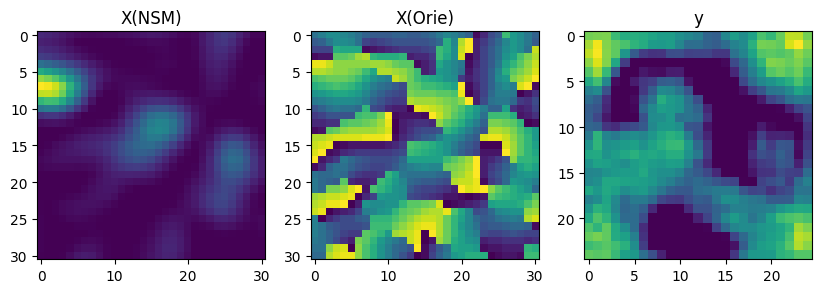

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2713, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2256, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2880, device='cuda:0') tensor(0.7850, device='cuda:0')


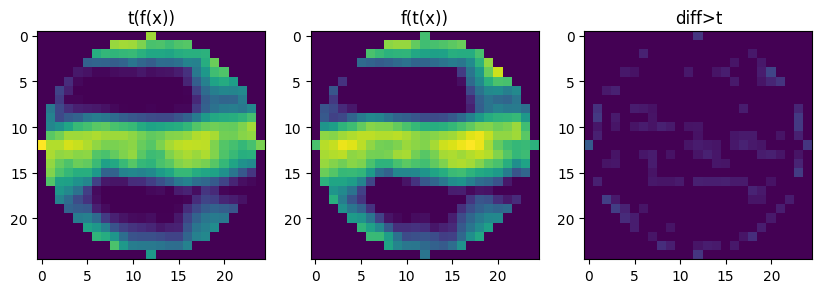

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2851, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2601, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1517, device='cuda:0') tensor(0.7653, device='cuda:0')


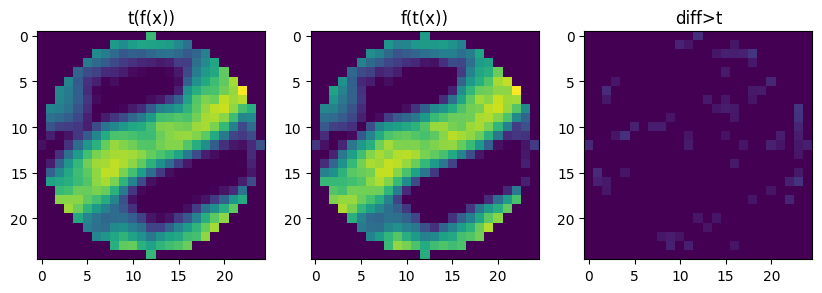

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.1895, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2176, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1200, device='cuda:0') tensor(0.6383, device='cuda:0')


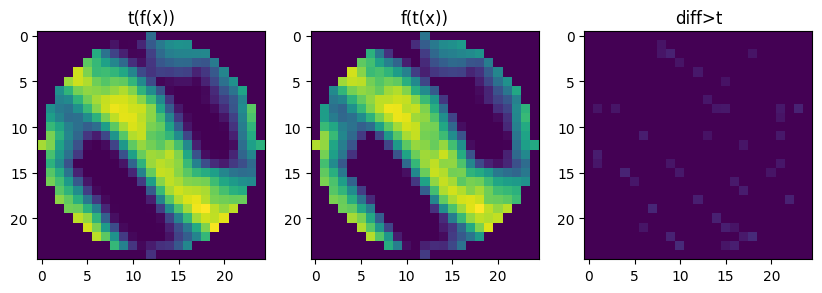

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2474, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2368, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2750, device='cuda:0') tensor(0.7576, device='cuda:0')


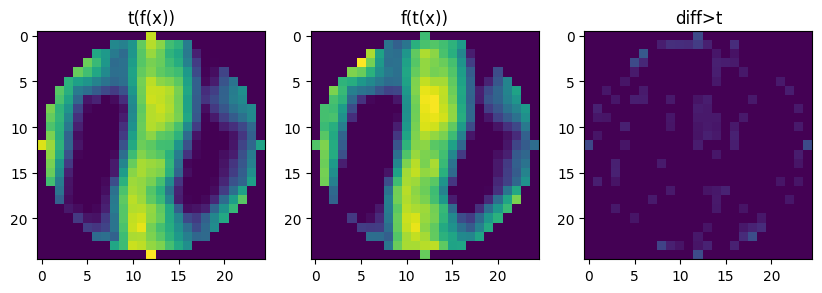

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2110, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2843, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3132, device='cuda:0') tensor(0.7644, device='cuda:0')


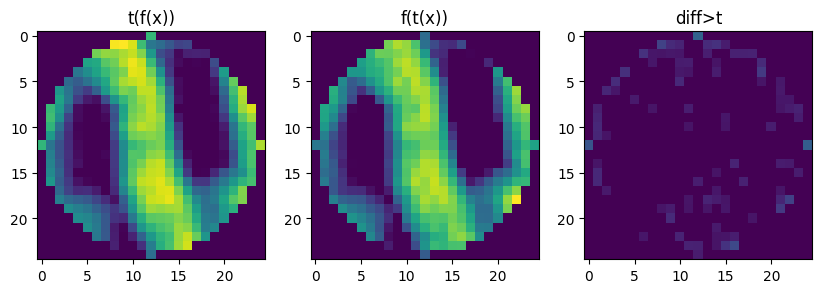

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2110, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2843, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3132, device='cuda:0') tensor(0.7644, device='cuda:0')


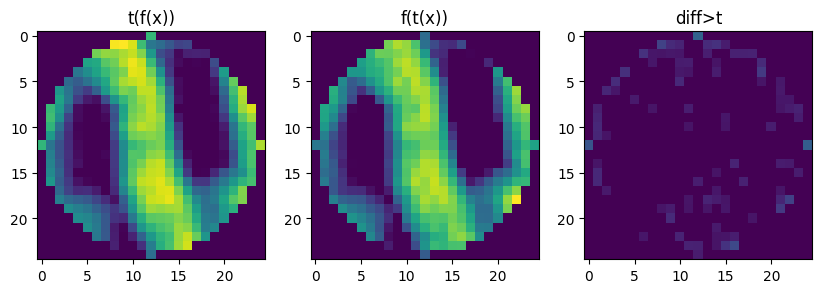

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2828, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2451, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2081, device='cuda:0') tensor(0.7789, device='cuda:0')


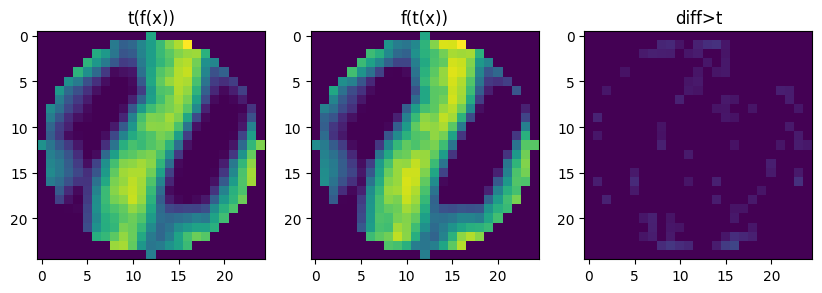

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.3828, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2210, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2949, device='cuda:0') tensor(0.7533, device='cuda:0')


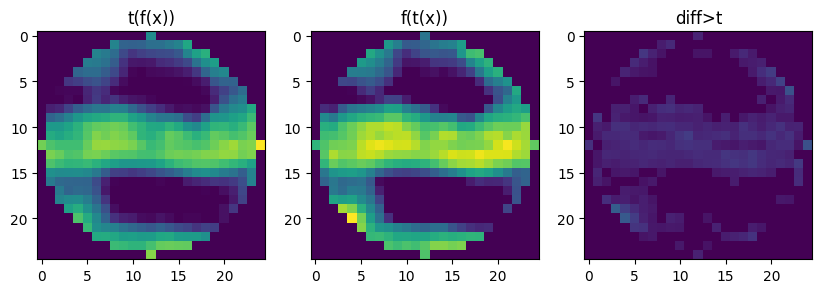

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2607, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2369, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2722, device='cuda:0') tensor(0.7630, device='cuda:0')


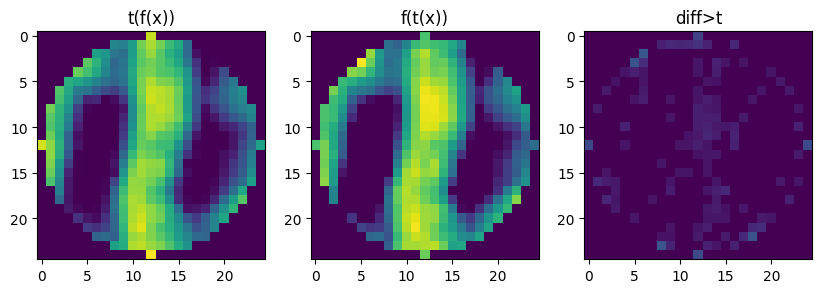

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2916, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(1.2534, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1718, device='cuda:0') tensor(0.7326, device='cuda:0')


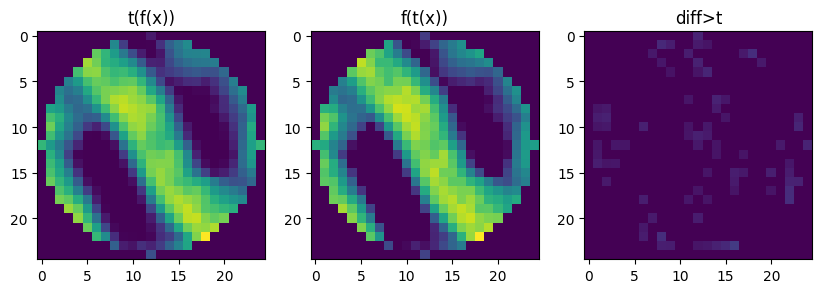

In [84]:
model_feature = model.feature
model_discriminator = model.discriminator

torch.manual_seed(42)
angles =  torch.tensor(np.random.uniform(low=0.0, high=360.0, size=10)//1, dtype=torch.float32).to(device)



iterator=iter(test_loader)
data = next(iterator)
index = 5 
with torch.no_grad():
    y = model_feature(data)
    c_mask = create_circular_mask(y.shape[2],y.shape[3])
    c_mask = torch.tensor(c_mask).to(device)

    show_images(normalize_tensor(data[index,0]),normalize_tensor(data[index,1]),normalize_tensor(y[index,0]),title1="X(NSM)",title2="X(Orie)",title3="y")
    for angle in angles:
        data_rotated, y_rotated = rotate_images(data, y, angle)
        y_rotated2 = model_feature(data_rotated)
        
        distance =model_discriminator(y_rotated,y_rotated2)
        y_rotated2 = y_rotated2*c_mask
        y_rotated = y_rotated*c_mask

        y1n=normalize_tensor(y_rotated[0,0])
        y2n=normalize_tensor(y_rotated2[0,0])

        print(y1n.min(),y_rotated.min(),y1n.max(),y_rotated.max())
        print(y2n.min(),y_rotated2.min(),y2n.max(),y_rotated2.max())
        
        diff = abs(y2n - y1n)
        t = 0.05
        diff[abs(diff) < t] = 0

        print(diff.min(),diff.max(),distance[0])
        show_images(y1n,y2n,diff,title1="t(f(x))",title2="f(t(x))",title3="diff>t")

In [91]:
def copy_tensor(tensor,times):
    tensor = tensor.repeat(times,1,1,1)
    return tensor

size = len(data)
with torch.no_grad():
  for i in range(size):
    img_temp = data[i][None]

    img_temp2 =random_transform(img_temp)
    diff = abs(img_temp2 - img_temp)
    
    data_temp = copy_tensor(img_temp2,size)
    data_temp =random_transform(data_temp)
    distances = model(data_temp,data)
    # print(distances)
    # print("diff ",diff.min(),diff.max())
    print("index: ",i," found in ",distances.argmin().item()," position ")

index:  0  found in  0  position 
index:  1  found in  1  position 
index:  2  found in  2  position 
index:  3  found in  3  position 
index:  4  found in  2  position 
index:  5  found in  5  position 
index:  6  found in  6  position 
index:  7  found in  7  position 
index:  8  found in  8  position 
index:  9  found in  9  position 


In [86]:
c_mask = create_circular_mask(data.shape[2],data.shape[3])
c_mask = torch.tensor(c_mask).to(device)

dist = model(data*c_mask,data*c_mask)
print(dist.argmin().item(),dist)

t = torch.ones(10,2,31,31).to(device)
dist = model(data,t*c_mask)
print(dist.argmin().item(),dist)

7 tensor([0.5374, 0.5360, 0.5350, 0.5395, 0.5367, 0.5356, 0.5395, 0.5331, 0.5452,
        0.5334], device='cuda:0', grad_fn=<SigmoidBackward0>)
0 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


tensor(0., device='cuda:0') tensor(12.3923, device='cuda:0') tensor(1.0544, device='cuda:0')
tensor(0., device='cuda:0') tensor(12., device='cuda:0') tensor(0.7492, device='cuda:0')


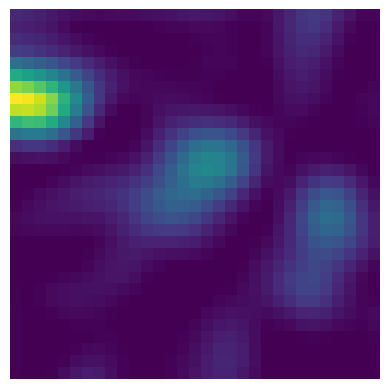

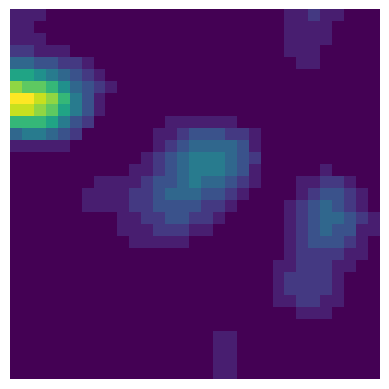

In [87]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Carregar a imagem em tons de cinza como um tensor
gray_image = data[5,0]

# Reduzir a quantidade de cores para 16
num_colors = 9
print(gray_image.min(),gray_image.max(),gray_image.mean())
quantized_image = torch.floor_divide(gray_image, 9 // num_colors) * (9 // num_colors)
print(quantized_image.min(),quantized_image.max(),quantized_image.mean())


plt.imshow(gray_image.cpu().numpy())
plt.axis('off')
plt.show()
# Mostrar a imagem quantizada
plt.imshow(quantized_image.cpu().numpy())
plt.axis('off')
plt.show()


In [88]:
import torch
import torchvision.transforms as transforms

# Crie um tensor de exemplo
tensor = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])

# Normalize o tensor entre 0 e 1
normalized_tensor =  torch.nn.functional.normalize(tensor, p=2, dim=0)
normalized_tensor2 = torch.norm(tensor, p=2, dim=0)
print("Tensor normalizado:", normalized_tensor,normalized_tensor2)


Tensor normalizado: tensor([0.1348, 0.2697, 0.4045, 0.5394, 0.6742]) tensor(7.4162)
